In [1]:
import argparse
import os

import mmcv
import torch
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint
from tools.fuse_conv_bn import fuse_module

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.core import wrap_fp16_model
from mmdet.datasets import build_dataloader, build_dataset
from mmdet.models import build_detector

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/home/mislam22/miniconda3/envs/orientedreppoints/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# !pip install timm==0.4.12
# !pip install easyfsl==1.0.0
# !pip install torch==1.4.0 torchvision==0.5.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!python -c "import torch;print(torch.__version__)"

1.4.0


In [21]:
cfg = mmcv.Config.fromfile("configs/dota/orientedrepoints_r50_demo.py")
# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True
cfg.model.pretrained = None
cfg.data.test.test_mode = True

# build the model and load checkpoint
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)
checkpoint = load_checkpoint(model, "work_dirs/orientedreppoints_r50_demo/epoch_40.pth", map_location='cpu')

if 'CLASSES' in checkpoint['meta']:
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES

model = MMDataParallel(model, device_ids=[0])
model

MMDataParallel(
  (module): OrientedRepPointsDetector(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [21]:
#!pip install easyfsl

  Using cached easyfsl-1.2.1-py3-none-any.whl (46 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 15.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 713.6 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0+cu100
    Uninstalling torch-1.4.0+cu100:
      Successfully uninstalled torch-1.4.0+cu100
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.4.0+cu92
    Uninstalling torchvision-0.4.0+cu92:
      Successfully uninstalled torchvision-0.4.0+cu92


In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
import pickle

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [22]:
model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
model.fc = nn.Flatten()
model

MMDataParallel(
  (module): OrientedRepPointsDetector(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [7]:
import os
image_path='train_custom_data/'
filenames = [name for name in os.listdir(image_path) if os.path.splitext(name)[-1] == '.tif']
filenames

['m_3809110_se_15_060_20200617.tif',
 'm_4008850_sw_16_060_20191001.tif',
 'm_4107004_nw_19_060_20210904.tif',
 'm_4108838_se_16_060_20190809.tif',
 'm_4108855_nw_16_060_20190809.tif',
 'm_4109022_ne_15_060_20190802.tif',
 'm_4209158_ne_15_060_20190804.tif',
 's_3407940_ne_17_060_20221004.tif',
 's_3507954_nw_17_060_20220530.tif',
 's_3607845_ne_17_060_20220927.tif',
 's_3607846_nw_17_060_20220606.tif',
 's_4007454_nw_18_060_20220720.tif',
 's_4207319_ne_18_060_20190805.tif',
 's_4307755_ne_18_060_20210926.tif',
 't_3408312_se_17_060_20191023.tif',
 't_3409340_ne_15_060_20190816.tif',
 't_4107339_se_18_060_20180810.tif',
 't_4107407_nw_18_060_20190917.tif',
 't_4406803_se_19_060_20180721.tif',
 't_4407220_se_18_060_20190102.tif',
 't_4709344_se_15_060_20191007.tif']

In [8]:
import torch 
from skimage import io,img_as_float
path = 'm_3809110_se_15_060_20200617.tif'
img = io.imread(image_path+path)
img = torch.tensor(img)

In [10]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 3.8 MB/s eta 0:00:00a 0:00:01


In [11]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from torchvision.transforms import ToTensor

class ImageData():
    def __init__(self, data_dir, transform):
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_excel(data_dir+'labels.xlsx')
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Third column is for an operation indicator
        self.operation_arr = np.asarray(self.data_info.iloc[:, 2])
        # Calculate len
        self.data_len = len(self.data_info.index)
        self.transform = transform
        
    def __len__(self):
        return len(self.data_len)
    
    def __getitem__(self, index):       
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = io.imread(image_path+single_image_name)
    
        # Check if there is an operation
        some_operation = self.operation_arr[index]
        # If there is an operation
        if some_operation:
            # Do some operation on image
            # ...
            # ...
            pass
        # Transform image to tensor
        img_as_tensor = self.transform(img_as_img)
        # img_as_tensor = self.to_tensor(img_as_tensor)

        # Get label of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, int(single_image_label))

image_size = 28
data_transf = transforms.Compose(
            [transforms.ToPILImage('RGBA'),
            transforms.Resize((224,224)),
            # transforms.RandomRotation(137.5),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3])
            #  transforms.Normalize(mean = [0.610, 0.377, 0.233],
                                  # std = [0.377, 0.233, 0.144])
            ])

image_path='train_custom_data/'
df=image_path+filenames[0]
data = ImageData(data_dir=image_path, transform = data_transf)
# trainloader = DataLoader(dataset = train_data, batch_size=4)

In [12]:
data[0][0].shape

torch.Size([3, 224, 224])

In [13]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [23]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, base_model: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.base_model = base_model

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        #z_support_ = self.backbone.forward(support_images)
        z_support_ = self.base_model.module.backbone.forward(support_images)
        for z in z_support_:
          print(z.shape)
        z_support = z_support_[-1].reshape(9, 100352)
        #z_query_ = self.backbone.forward(query_images)
        z_query_ = self.base_model.module.backbone.forward(query_images)
        z_query = z_query_[-1].reshape(12, 100352)

        # z_support = self.backbone.forward(support_images)
        # z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


# convolutional_network = resnet18(pretrained=True)
# convolutional_network.fc = nn.Flatten()
# print(convolutional_network)

model = PrototypicalNetworks(model).cuda()
model

PrototypicalNetworks(
  (base_model): MMDataParallel(
    (module): OrientedRepPointsDetector(
      (backbone): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=

In [15]:
N_WAY = 3  # Number of classes in a task
N_SHOT = 3  # Number of images per class in the support set
N_QUERY = 4  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
data.get_labels = lambda: [
    (instance[1]) for instance in data
]
test_sampler = TaskSampler(
    data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    data,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

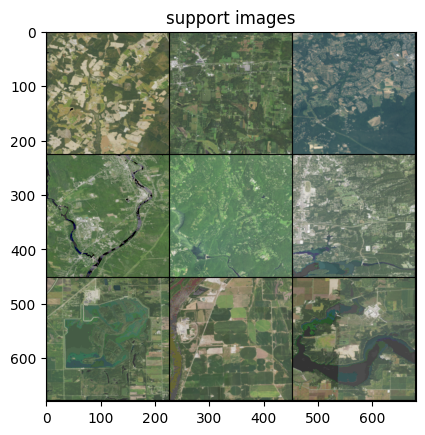

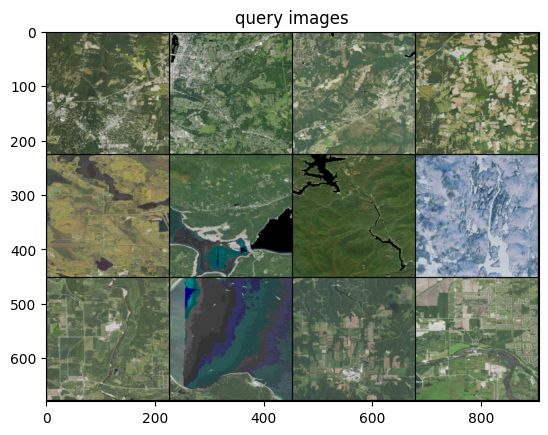

In [16]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [24]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)


torch.Size([9, 256, 56, 56])
torch.Size([9, 512, 28, 28])
torch.Size([9, 1024, 14, 14])
torch.Size([9, 2048, 7, 7])


In [28]:
example_predicted_labels.cpu()

tensor([2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 0])

In [29]:
example_query_labels

tensor([2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0])

In [33]:
sum(example_predicted_labels.cpu()==example_query_labels)

tensor(7)